In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = '02172021'
ds_folder = f'../data/{ds_name}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/02172021/test.csv
../data/02172021/train.csv
../data/02172021/edges.csv
../data/02172021/cluster_dynamics.csv
../data/02172021/split/test.csv
../data/02172021/split/train.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [3]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/cluster_dynamics.csv')
edge_df = pd.read_csv(f'{ds_folder}/edges.csv')

In [4]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (586165, 19)
Shape of edge data is (585751, 5)


In [5]:
#check the train data
node_df.tail()

# so there are around 19 features here in this dataset

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,node
586160,c8,971,E,static,NaN,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,658
586161,c8,971,E,static,NaN,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,733
586162,c8,971,E,static,NaN,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,729
586163,c8,971,E,static,NaN,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,383
586164,c8,971,E,static,NaN,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,650


In [6]:
#information about the node data set
node_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586165 entries, 0 to 586164
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cluster_id            586165 non-null  object 
 1   sim                   586165 non-null  int64  
 2   state                 93024 non-null   object 
 3   dynamic               93024 non-null   object 
 4   dynamic_model         25077 non-null   object 
 5   v_sampling_fraction   93024 non-null   float64
 6   v_cluster_size        93024 non-null   float64
 7   v_timespan            93024 non-null   float64
 8   gamma                 93024 non-null   float64
 9   oster                 93024 non-null   float64
 10  birth_rate            93024 non-null   float64
 11  PD                    93024 non-null   float64
 12  R0                    93024 non-null   float64
 13  abs_growth_rate       93024 non-null   float64
 14  fraction_time_growth  93024 non-null   float64
 15  

In [7]:
node_df.describe()

,sim,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,cherries,node
count,586165.000000,93024.000000,93024.000000,93024.000000,9.302400e+04,93024.000000,9.302400e+04,93024.000000,9.302400e+04,9.302400e+04,93024.000000,9.302400e+04,93024.000000,586165.000000
mean,2570.742381,0.672865,68.695240,21.875075,inf,21.903749,2.325858e+03,296.668483,-1.396918e+04,2.643251e+03,0.438592,-2.176491e+03,0.312647,717.760486
std,1497.253401,0.236493,87.813789,13.795856,NaN,13.776248,4.843725e+04,301.888022,7.396936e+05,9.385083e+04,0.344269,8.956801e+04,0.052902,425.309897
min,2.000000,0.052218,5.000000,3.000000,-8.616953e+01,3.095238,2.173863e-02,6.000000,-7.902710e+07,5.155155e-03,0.000000,-8.644998e+06,0.090909,1.000000
25%,1285.000000,0.519904,20.000000,10.000000,-1.476354e+00,10.032172,8.387047e-02,61.000000,-1.827523e+00,2.013252e+00,0.105263,4.118389e+00,0.285714,354.000000
50%,2569.000000,0.714299,50.000000,19.000000,-4.723775e-01,19.019440,1.283865e-01,239.000000,5.013867e-01,3.787565e+00,0.400000,2.274047e+01,0.315789,708.000000
75%,3961.000000,0.872061,78.000000,32.000000,4.317760e-01,32.011151,2.399995e-01,427.000000,1.938066e+00,6.348452e+00,0.722222,4.990437e+01,0.341463,1063.000000
max,5000.000000,0.999975,936.000000,72.000000,inf,72.004715,2.168821e+06,2558.000000,6.709768e+00,8.644998e+06,1.000000,8.547637e+03,0.500000,2115.000000


In [8]:
# import pandas_profiling
# node_df.profile_report() 

In [9]:
#check for the missing values in the node data
node_df.isnull().sum()

cluster_id                   0
sim                          0
state                   493141
dynamic                 493141
dynamic_model           561088
v_sampling_fraction     493141
v_cluster_size          493141
v_timespan              493141
gamma                   493141
oster                   493141
birth_rate              493141
PD                      493141
R0                      493141
abs_growth_rate         493141
fraction_time_growth    493141
r_max                   493141
ltt_shape               493141
cherries                493141
node                         0
dtype: int64

In [10]:
# Check which variables have missing values

node_columns_with_missing_values = node_df.columns[node_df.isnull().any()]
node_df[node_columns_with_missing_values].isnull().sum()

state                   493141
dynamic                 493141
dynamic_model           561088
v_sampling_fraction     493141
v_cluster_size          493141
v_timespan              493141
gamma                   493141
oster                   493141
birth_rate              493141
PD                      493141
R0                      493141
abs_growth_rate         493141
fraction_time_growth    493141
r_max                   493141
ltt_shape               493141
cherries                493141
dtype: int64

In [11]:
# total missing values in the entire df
node_df.isnull().sum().sum()

7958203

In [12]:
missing_series = node_df.isnull().sum() 
missing_series.where(missing_series>1000)
missing_series.loc[missing_series>1000]/node_df.shape[0] # to locate the missing values that are more than 1000

state                   0.841301
dynamic                 0.841301
dynamic_model           0.957219
v_sampling_fraction     0.841301
v_cluster_size          0.841301
v_timespan              0.841301
gamma                   0.841301
oster                   0.841301
birth_rate              0.841301
PD                      0.841301
R0                      0.841301
abs_growth_rate         0.841301
fraction_time_growth    0.841301
r_max                   0.841301
ltt_shape               0.841301
cherries                0.841301
dtype: float64

### Split the nodes into background and non-background

In [13]:
background_df = node_df[node_df['cluster_id']=='Background']
background_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,node
0,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,376
2,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440
3,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924
4,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160


In [14]:
node_df = node_df[node_df['cluster_id']!='Background']
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,node
1149,c1,1001,A,static,NaN,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,285
1150,c1,1001,A,static,NaN,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,1116
1151,c1,1001,A,static,NaN,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,81
1152,c1,1001,A,static,NaN,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,112
1153,c1,1001,A,static,NaN,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,1128


In [15]:
node_df.describe()

,sim,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,cherries,node
count,93024.000000,93024.000000,93024.000000,93024.000000,9.302400e+04,93024.000000,9.302400e+04,93024.000000,9.302400e+04,9.302400e+04,93024.000000,9.302400e+04,93024.000000,93024.000000
mean,2563.853339,0.672865,68.695240,21.875075,inf,21.903749,2.325858e+03,296.668483,-1.396918e+04,2.643251e+03,0.438592,-2.176491e+03,0.312647,739.634406
std,1510.490389,0.236493,87.813789,13.795856,NaN,13.776248,4.843725e+04,301.888022,7.396936e+05,9.385083e+04,0.344269,8.956801e+04,0.052902,393.030583
min,2.000000,0.052218,5.000000,3.000000,-8.616953e+01,3.095238,2.173863e-02,6.000000,-7.902710e+07,5.155155e-03,0.000000,-8.644998e+06,0.090909,1.000000
25%,1260.000000,0.519904,20.000000,10.000000,-1.476354e+00,10.032172,8.387047e-02,61.000000,-1.827523e+00,2.013252e+00,0.105263,4.118389e+00,0.285714,439.000000
50%,2569.000000,0.714299,50.000000,19.000000,-4.723775e-01,19.019440,1.283865e-01,239.000000,5.013867e-01,3.787565e+00,0.400000,2.274047e+01,0.315789,695.000000
75%,3966.000000,0.872061,78.000000,32.000000,4.317760e-01,32.011151,2.399995e-01,427.000000,1.938066e+00,6.348452e+00,0.722222,4.990437e+01,0.341463,1045.000000
max,5000.000000,0.999975,936.000000,72.000000,inf,72.004715,2.168821e+06,2558.000000,6.709768e+00,8.644998e+06,1.000000,8.547637e+03,0.500000,2003.000000


### Preprocessing-1
1. Impute the missing value for dynamic_model

In [16]:
node_df['dynamic_model'].unique()

array([nan, 'lin', 'exp'], dtype=object)

In [17]:
# impute the missing values in dynamic_model using "stable"
dynamic_model_values = {'dynamic_model': 'stable'}
tmp = node_df[node_df['cluster_id']!='Background'].fillna(value=dynamic_model_values)
node_df.loc[node_df['cluster_id']!='Background', 'dynamic_model'] = tmp['dynamic_model']

In [18]:
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,node
1149,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,285
1150,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,1116
1151,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,81
1152,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,112
1153,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,0.08401,621.0,4.252644,5.712117,0.642857,68.023586,concave,0.296875,1128


In [19]:
node_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,node
586160,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,658
586161,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,733
586162,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,729
586163,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,383
586164,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,76820.64594,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,650


In [20]:
# Check which variables have missing values

node_columns_with_missing_values = node_df.columns[node_df.isnull().any()]
node_df[node_columns_with_missing_values].isnull().sum()

Series([], dtype: float64)

<AxesSubplot:>

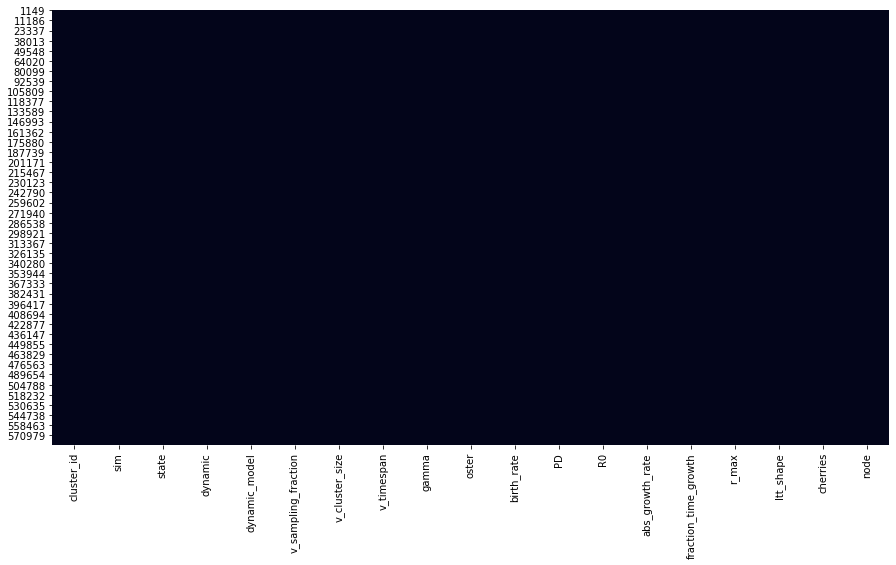

In [21]:
# Now using heatmaps
plt.figure(figsize=(15,8))
sns.heatmap(node_df.isnull(), cbar=False)
# FRom this heatmap too it is evident that the above 2 mentioned vars have more missing values

<AxesSubplot:>

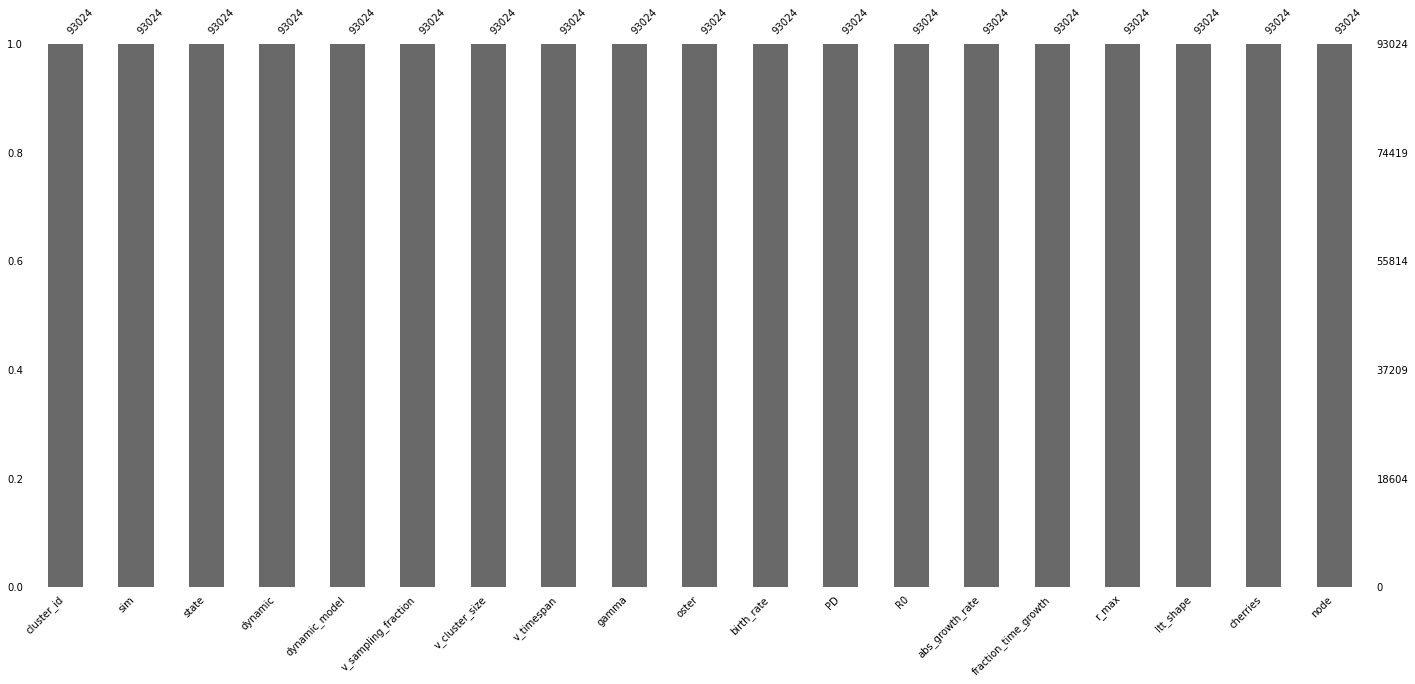

In [22]:
# Next is to use the missingno library to analyze the missing values
import missingno as msno 

msno.bar(node_df,labels=True,fontsize=10) 

/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/seaborn/matrix.py:301: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/seaborn/matrix.py:301: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<AxesSubplot:>

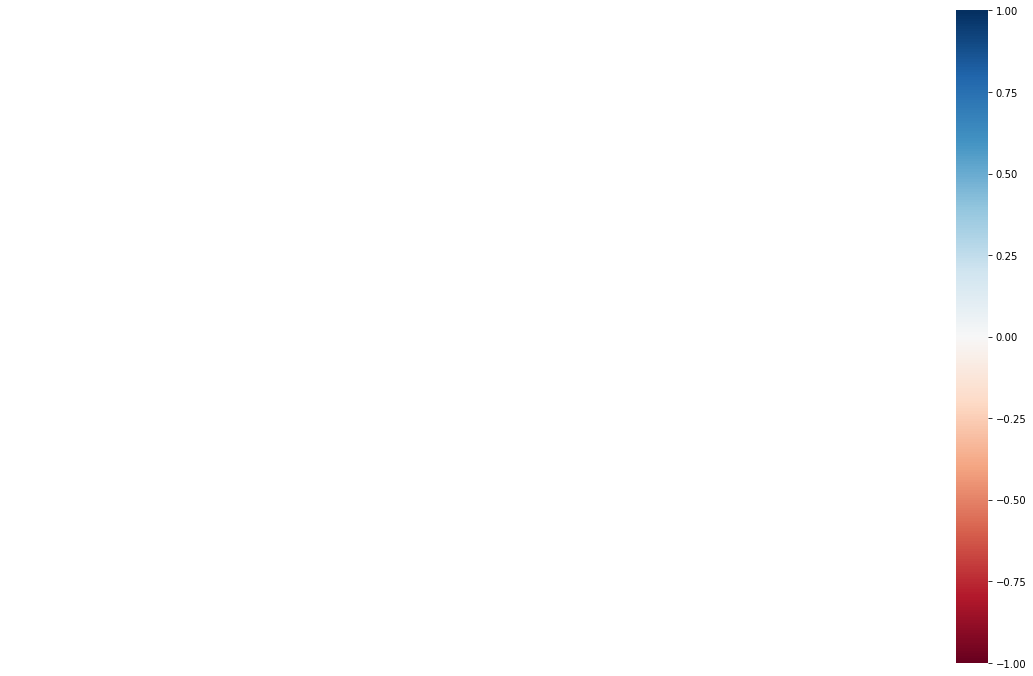

In [23]:
# The missingno correlation heatmap measures nullity correlation: 
# how strongly the presence or absence of one variable affects the presence of another:
msno.heatmap(node_df,labels=True) 

# Entries marked <1 or >-1 have a correlation that is close to being exactingly negative or positive, but is still not quite perfectly so
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does)

### Count number of trees

In [24]:
tree_ids = node_df['sim'].unique()
num_trees = len(tree_ids)
print(f'Number of trees: {num_trees}')

Number of trees: 414


## The following pre-processing is only for non-background nodes
### Preprocessing-2: cherries

* Drop the missing values
* Fill with meaningful values
* Fill with stat values 
    * **cherries**: median, mean, max, condition on the sampling fraction to choose the best one.

#### The boxplot reference

![boxPlot](../img/boxplot_ref.png)

####  Impute the missing value for cherries (TBD)

### Preprocessing-3: Discretization
#### 3-1. R0 discretization
   * 3 ranges: $(-inf, 0]$, $(0, 1]$, $(1, +inf)$

count    9.302400e+04
mean    -1.396918e+04
std      7.396936e+05
min     -7.902710e+07
25%     -1.827523e+00
50%      5.013867e-01
75%      1.938066e+00
max      6.709768e+00
Name: R0, dtype: float64


<AxesSubplot:xlabel='R0'>

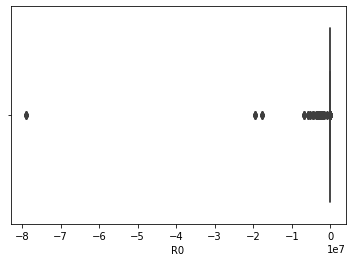

In [25]:
print(node_df['R0'].describe())
# f, ax = plt.subplots(figsize=(10, 6))
# ax.set_xscale("log")
sns.boxplot(x=node_df[node_df['R0'].notna()]['R0'])
# ax.xaxis.grid(True)

In [26]:
bins = pd.IntervalIndex.from_tuples([(float('-inf'), 0), (0, 1), (1, float('inf'))], closed='right')
print(bins)
r0_cats = pd.cut(node_df['R0'], bins)
r0_cat_dict = {cat: i for i, cat in enumerate(bins)}
print(r0_cat_dict)

IntervalIndex([(-inf, 0.0], (0.0, 1.0], (1.0, inf]],
              closed='right',
              dtype='interval[float64]')
{Interval(-inf, 0.0, closed='right'): 0, Interval(0.0, 1.0, closed='right'): 1, Interval(1.0, inf, closed='right'): 2}


In [27]:
node_df['R0_bin'] = r0_cats
node_df['R0_cat'] = node_df['R0_bin'].replace(r0_cat_dict, inplace=False)
node_df['R0_cat'].unique()

array([2, 1, 0])

In [28]:
node_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,node,R0_bin,R0_cat
586160,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,658,"(1.0, inf]",2
586161,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,733,"(1.0, inf]",2
586162,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,729,"(1.0, inf]",2
586163,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,383,"(1.0, inf]",2
586164,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,30.0,2.561986,0.622258,1.0,1.244515,convex,0.333333,650,"(1.0, inf]",2


#### Deprecate processing for R0 with Quantile-based discretization function. (Skip the below cell)

#### 3-2. Gamma discretization
    * Quantile-based discretization function

In [29]:
gamma_cats, gamma_bins = pd.qcut(node_df['gamma'], 4, retbins=True, duplicates='drop')
gamma_cat_dict = {cat: i for i, cat in enumerate(gamma_cats.unique())}
print(gamma_bins)
print(gamma_cat_dict)

[-86.16952768  -1.47635432  -0.47237749   0.43177598          inf]
{Interval(0.432, inf, closed='right'): 0, Interval(-0.472, 0.432, closed='right'): 1, Interval(-86.171, -1.476, closed='right'): 2, Interval(-1.476, -0.472, closed='right'): 3}


In [30]:
node_df['gamma_bin'] = gamma_cats
node_df['gamma_cat'] = node_df['gamma_bin'].replace(gamma_cat_dict, inplace=False)
print(f'Gamma cat: {node_df["gamma_cat"].unique()}')
node_df.head()

Gamma cat: [0 1 2 3]


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,node,R0_bin,R0_cat,gamma_bin,gamma_cat
1149,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,285,"(1.0, inf]",2,"(0.432, inf]",0
1150,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,1116,"(1.0, inf]",2,"(0.432, inf]",0
1151,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,81,"(1.0, inf]",2,"(0.432, inf]",0
1152,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,112,"(1.0, inf]",2,"(0.432, inf]",0
1153,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,1128,"(1.0, inf]",2,"(0.432, inf]",0


### Preprocessing-4 Encode the categorical feature and label
#### 4.1 Categorical features
    * dynamic_model
    * ltt_shape
    * R0 (processed before)
    * gamma (processed before)

In [31]:
# Use to record all the feature transformations
feat_dict = dict()

In [32]:
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,node,R0_bin,R0_cat,gamma_bin,gamma_cat
1149,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,285,"(1.0, inf]",2,"(0.432, inf]",0
1150,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,1116,"(1.0, inf]",2,"(0.432, inf]",0
1151,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,81,"(1.0, inf]",2,"(0.432, inf]",0
1152,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,112,"(1.0, inf]",2,"(0.432, inf]",0
1153,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,5.712117,0.642857,68.023586,concave,0.296875,1128,"(1.0, inf]",2,"(0.432, inf]",0


In [33]:
#First of all we need to get the columns where the categorical features are present
# idea is to extract all the columns with type as object
node_df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64'),
       CategoricalDtype(categories=[(-inf, 0.0], (0.0, 1.0], (1.0, inf]],
              ordered=True),
       CategoricalDtype(categories=[(-86.171, -1.476], (-1.476, -0.472], (-0.472, 0.432], (0.432, inf]],
              ordered=True)], dtype=object)

In [34]:
for types in node_df.dtypes.unique():
    print(types,len(node_df.select_dtypes(types).columns))
    print(node_df.select_dtypes(types).columns)
    print('===')

object 5
Index(['cluster_id', 'state', 'dynamic', 'dynamic_model', 'ltt_shape'], dtype='object')
===
int64 4
Index(['sim', 'node', 'R0_cat', 'gamma_cat'], dtype='object')
===
float64 12
Index(['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'gamma', 'oster',
       'birth_rate', 'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth',
       'r_max', 'cherries'],
      dtype='object')
===
category 2
Index(['R0_bin', 'gamma_bin'], dtype='object')
===
category 2
Index(['R0_bin', 'gamma_bin'], dtype='object')
===


In [35]:
# Category the ltt_shape and dynamic_model

# node_df = node_df.astype({'ltt_shape': 'category'}, copy=False)
node_df["ltt_shape"] = node_df["ltt_shape"].astype('category')
node_df["ltt_shape_cat"] = node_df["ltt_shape"].cat.codes
feat_dict['ltt_shape'] = dict(enumerate(node_df['ltt_shape'].cat.categories))
      
node_df["dynamic_model"] = node_df["dynamic_model"].astype('category')
node_df["dynamic_model_cat"] = node_df["dynamic_model"].cat.codes
feat_dict['dynamic_model'] = dict(enumerate(node_df['dynamic_model'].cat.categories))
print(feat_dict)
node_df.head()

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'dynamic_model': {0: 'exp', 1: 'lin', 2: 'stable'}}


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,r_max,ltt_shape,cherries,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_model_cat
1149,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,68.023586,concave,0.296875,285,"(1.0, inf]",2,"(0.432, inf]",0,0,2
1150,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,68.023586,concave,0.296875,1116,"(1.0, inf]",2,"(0.432, inf]",0,0,2
1151,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,68.023586,concave,0.296875,81,"(1.0, inf]",2,"(0.432, inf]",0,0,2
1152,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,68.023586,concave,0.296875,112,"(1.0, inf]",2,"(0.432, inf]",0,0,2
1153,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,68.023586,concave,0.296875,1128,"(1.0, inf]",2,"(0.432, inf]",0,0,2


In [36]:
# Record the cat_dict for R0 and gamma, reverse the previous the dict
for feat_name, cat_dict in zip(['r0', 'gamma'], [r0_cat_dict, gamma_cat_dict]):
    tmp_dict = {}
    for k, v in cat_dict.items():
        tmp_dict[v] = f'{k.left, k.right, k.closed}'
    feat_dict[feat_name] = tmp_dict
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'dynamic_model': {0: 'exp', 1: 'lin', 2: 'stable'}, 'r0': {0: "(-inf, 0.0, 'right')", 1: "(0.0, 1.0, 'right')", 2: "(1.0, inf, 'right')"}, 'gamma': {0: "(0.432, inf, 'right')", 1: "(-0.472, 0.432, 'right')", 2: "(-86.171, -1.476, 'right')", 3: "(-1.476, -0.472, 'right')"}}


#### 4.2 Categorical label
* Convert the dynamic column to the int value

In [37]:
node_df["dynamic"] = node_df["dynamic"].astype('category')
node_df["dynamic_cat"] = node_df["dynamic"].cat.codes
feat_dict['dynamic'] = dict(enumerate(node_df['dynamic'].cat.categories))
print(feat_dict)
node_df.tail()

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'dynamic_model': {0: 'exp', 1: 'lin', 2: 'stable'}, 'r0': {0: "(-inf, 0.0, 'right')", 1: "(0.0, 1.0, 'right')", 2: "(1.0, inf, 'right')"}, 'gamma': {0: "(0.432, inf, 'right')", 1: "(-0.472, 0.432, 'right')", 2: "(-86.171, -1.476, 'right')", 3: "(-1.476, -0.472, 'right')"}, 'dynamic': {0: 'decay', 1: 'growth', 2: 'static'}}


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,ltt_shape,cherries,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_model_cat,dynamic_cat
586160,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,convex,0.333333,658,"(1.0, inf]",2,"(0.432, inf]",0,2,2,2
586161,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,convex,0.333333,733,"(1.0, inf]",2,"(0.432, inf]",0,2,2,2
586162,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,convex,0.333333,729,"(1.0, inf]",2,"(0.432, inf]",0,2,2,2
586163,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,convex,0.333333,383,"(1.0, inf]",2,"(0.432, inf]",0,2,2,2
586164,c8,971,E,static,stable,0.98394,12.0,6.0,1.574702,6.057895,...,convex,0.333333,650,"(1.0, inf]",2,"(0.432, inf]",0,2,2,2


### Analysis-1 Correlation 
#### 1-1. The relationship between categorical features and label

In [38]:
from sklearn.feature_selection import chi2, mutual_info_classif

cat_feat_cols = ['ltt_shape_cat', 'dynamic_model_cat', 'R0_cat', 'gamma_cat']
chi2_sts, p_vals = chi2(node_df[cat_feat_cols], node_df['dynamic_cat'])
mis = mutual_info_classif(node_df[cat_feat_cols], node_df['dynamic_cat'])

for cat, chi2, p_val, mi in zip(cat_feat_cols, chi2_sts, p_vals, mis):
    degree_freedom = (len(node_df['dynamic_cat'].unique()) - 1) * (len(node_df[cat].unique())-1)
    print(f'{cat}: \n  df: {degree_freedom}, chi2: {chi2}, p_vals: {p_val}\n  MI: {mi}')

ltt_shape_cat: 
  df: 6, chi2: 1086.3446396777326, p_vals: 1.2684074126100747e-236
  MI: 0.019812865777196764
dynamic_model_cat: 
  df: 4, chi2: 29671.032647872886, p_vals: 0.0
  MI: 0.6157572116386754
R0_cat: 
  df: 4, chi2: 1232.1643230130958, p_vals: 2.747368146684344e-268
  MI: 0.014122398704696337
gamma_cat: 
  df: 6, chi2: 491.55970270310365, p_vals: 1.816213063133552e-107
  MI: 0.028124541687933213


### Analysis-1
#### 1-2 The relationship between numerical features and label

In [39]:
num_feat_cols = ["v_sampling_fraction", "v_cluster_size", "v_timespan", "oster", "birth_rate", "PD",
                 "abs_growth_rate", "fraction_time_growth", "r_max","cherries"]

label_col = ["dynamic_cat"]
aly_col = num_feat_cols + cat_feat_cols + label_col
print(aly_col)

aly_df = node_df[aly_col]
print(aly_df.shape, f"num_feat: {len(num_feat_cols)}, cat_feat: {len(cat_feat_cols)}, label: {len(label_col)}")

['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'birth_rate', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'ltt_shape_cat', 'dynamic_model_cat', 'R0_cat', 'gamma_cat', 'dynamic_cat']
(93024, 15) num_feat: 10, cat_feat: 4, label: 1


#### 1-2-1 Pearson R

In [40]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_df.corr()

,v_sampling_fraction,v_cluster_size,v_timespan,oster,birth_rate,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,ltt_shape_cat,dynamic_model_cat,R0_cat,gamma_cat,dynamic_cat
v_sampling_fraction,1.000000,-0.567393,-0.309369,-0.309536,0.031944,-0.444549,-0.002153,0.042341,-0.009000,-0.170635,0.086035,-0.017887,0.100488,-0.309468,-0.008328
v_cluster_size,-0.567393,1.000000,0.577843,0.577976,-0.021306,0.889667,-0.015542,0.058533,0.018265,0.079776,-0.253862,0.190367,0.009167,0.166012,0.172496
v_timespan,-0.309369,0.577843,1.000000,0.999999,-0.055430,0.827725,-0.027861,0.063883,0.033184,0.074838,-0.259964,0.332844,0.044630,0.207980,0.388309
oster,-0.309536,0.577976,0.999999,1.000000,-0.055401,0.827826,-0.027686,0.063755,0.033004,0.074670,-0.259807,0.332788,0.044499,0.208155,0.388050
birth_rate,0.031944,-0.021306,-0.055430,-0.055401,1.000000,-0.039312,-0.001351,0.048008,0.001168,0.015542,0.016274,-0.026186,0.033514,-0.060553,-0.074906
PD,-0.444549,0.889667,0.827725,0.827826,-0.039312,1.000000,-0.023557,0.078346,0.023962,0.088992,-0.306840,0.299363,0.035218,0.227426,0.314466
abs_growth_rate,-0.002153,-0.015542,-0.027861,-0.027686,-0.001351,-0.023557,1.000000,-0.035812,-0.954229,0.014814,0.014973,-0.020005,-0.031113,0.012577,-0.034868
fraction_time_growth,0.042341,0.058533,0.063883,0.063755,0.048008,0.078346,-0.035812,1.000000,0.031596,0.004862,-0.017268,0.087771,0.267691,-0.080808,0.108802
r_max,-0.009000,0.018265,0.033184,0.033004,0.001168,0.023962,-0.954229,0.031596,1.000000,-0.007275,-0.011373,0.011429,0.027309,-0.010914,0.027383
cherries,-0.170635,0.079776,0.074838,0.074670,0.015542,0.088992,0.014814,0.004862,-0.007275,1.000000,-0.031120,0.014699,-0.022426,0.083223,0.040194


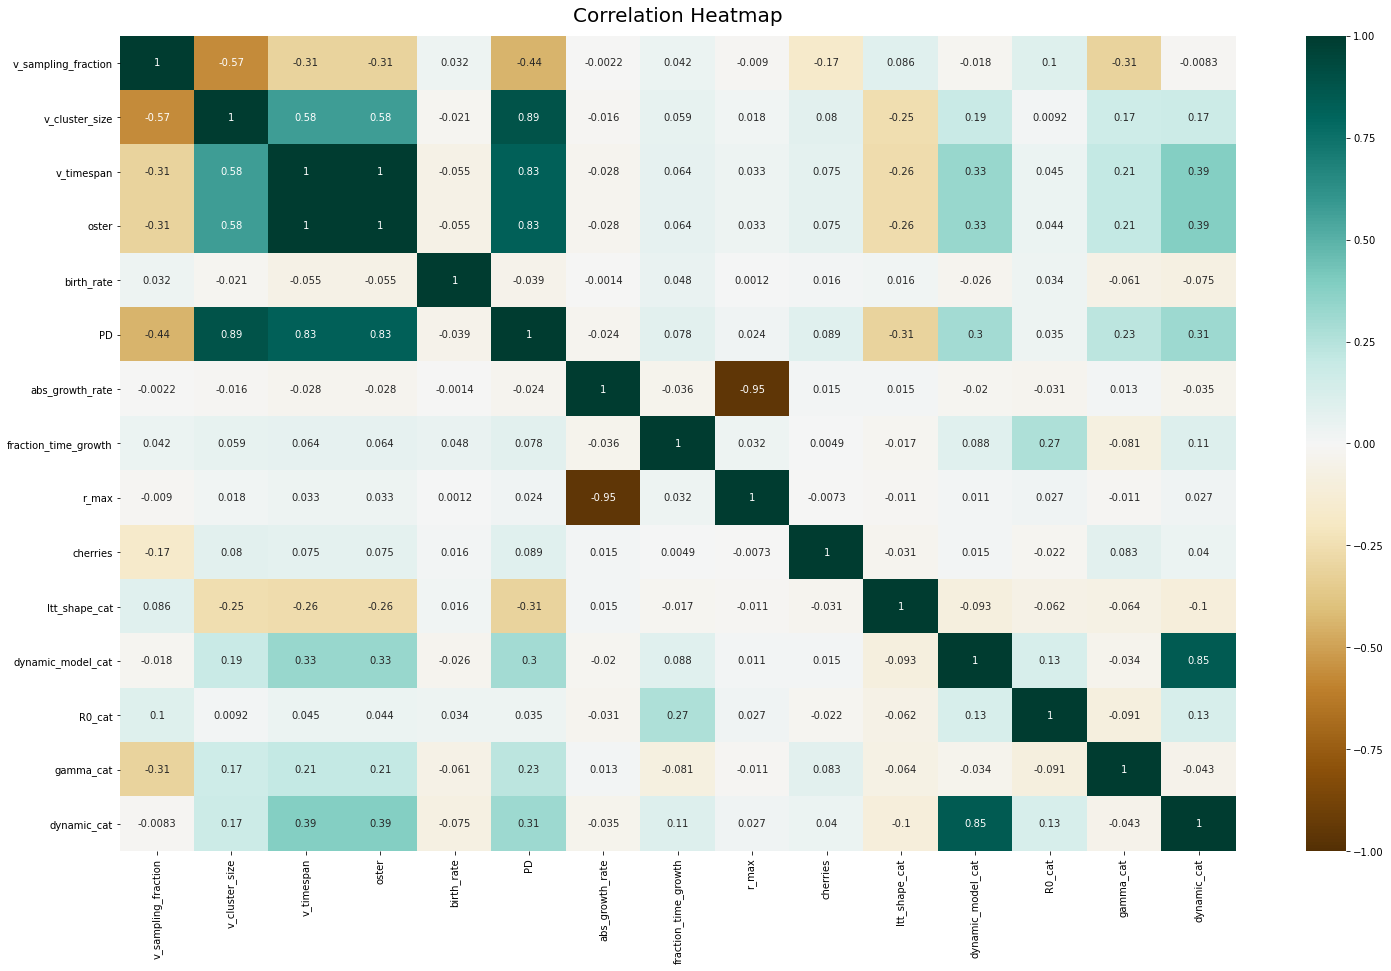

In [41]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(25, 15))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=14);

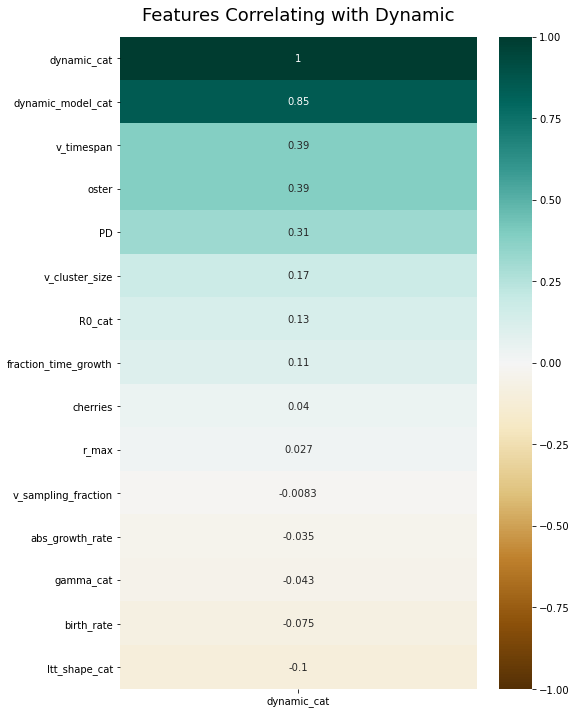

In [42]:
#check the features that are highly correlated to the output variable
plt.figure(figsize=(8, 12))
heatmap_outputvar = sns.heatmap(aly_df.corr()[['dynamic_cat']].sort_values(by='dynamic_cat', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap_outputvar.set_title('Features Correlating with Dynamic', fontdict={'fontsize':18}, pad=16);

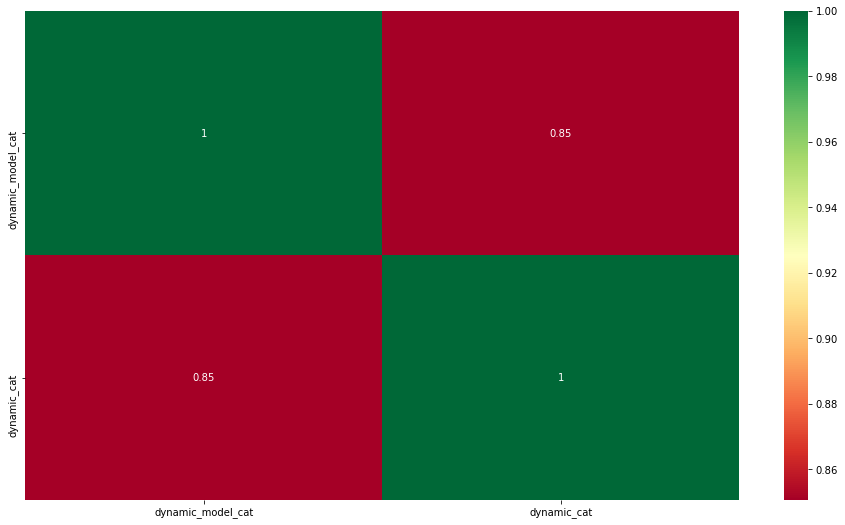

In [43]:
# most correlated features

corrmat = aly_df.corr()
top_corr_features = corrmat.index[abs(corrmat['dynamic_cat'])>0.45]
plt.figure(figsize=(16,9))
g = sns.heatmap(aly_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### 1-2-2 Spearman correlation

In [44]:
# Compute pairwise correlation of columns (Spearman rank correlation, non-linear)
aly_df.corr("spearman")

,v_sampling_fraction,v_cluster_size,v_timespan,oster,birth_rate,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,ltt_shape_cat,dynamic_model_cat,R0_cat,gamma_cat,dynamic_cat
v_sampling_fraction,1.000000,-0.447830,-0.230478,-0.239875,0.406082,-0.267170,-0.273803,0.040252,-0.251638,-0.197118,0.067088,-0.000262,0.088137,-0.316622,0.003581
v_cluster_size,-0.447830,1.000000,0.692606,0.688199,-0.475264,0.888154,0.499605,0.146274,0.739722,0.100840,-0.302736,0.288182,0.104211,0.219114,0.271656
v_timespan,-0.230478,0.692606,1.000000,0.999628,-0.822367,0.900485,0.336023,0.096296,0.807885,0.091295,-0.274430,0.387810,0.048199,0.201607,0.424216
oster,-0.239875,0.688199,0.999628,1.000000,-0.834620,0.898752,0.342252,0.091311,0.807442,0.094384,-0.275056,0.383589,0.042550,0.215561,0.420144
birth_rate,0.406082,-0.475264,-0.822367,-0.834620,1.000000,-0.704159,-0.435892,0.042960,-0.689596,-0.146089,0.239729,-0.201458,0.096937,-0.479230,-0.233480
PD,-0.267170,0.888154,0.900485,0.898752,-0.704159,1.000000,0.478000,0.138443,0.852265,0.105215,-0.340711,0.374596,0.085529,0.261084,0.384918
abs_growth_rate,-0.273803,0.499605,0.336023,0.342252,-0.435892,0.478000,1.000000,-0.149541,0.616661,0.070037,-0.179369,-0.012373,-0.237912,0.355813,-0.048495
fraction_time_growth,0.040252,0.146274,0.096296,0.091311,0.042960,0.138443,-0.149541,1.000000,0.175526,-0.008291,-0.029571,0.104033,0.269923,-0.079567,0.115071
r_max,-0.251638,0.739722,0.807885,0.807442,-0.689596,0.852265,0.616661,0.175526,1.000000,0.094114,-0.291879,0.264539,0.013955,0.241226,0.272149
cherries,-0.197118,0.100840,0.091295,0.094384,-0.146089,0.105215,0.070037,-0.008291,0.094114,1.000000,-0.026488,0.032407,-0.036031,0.099788,0.046358


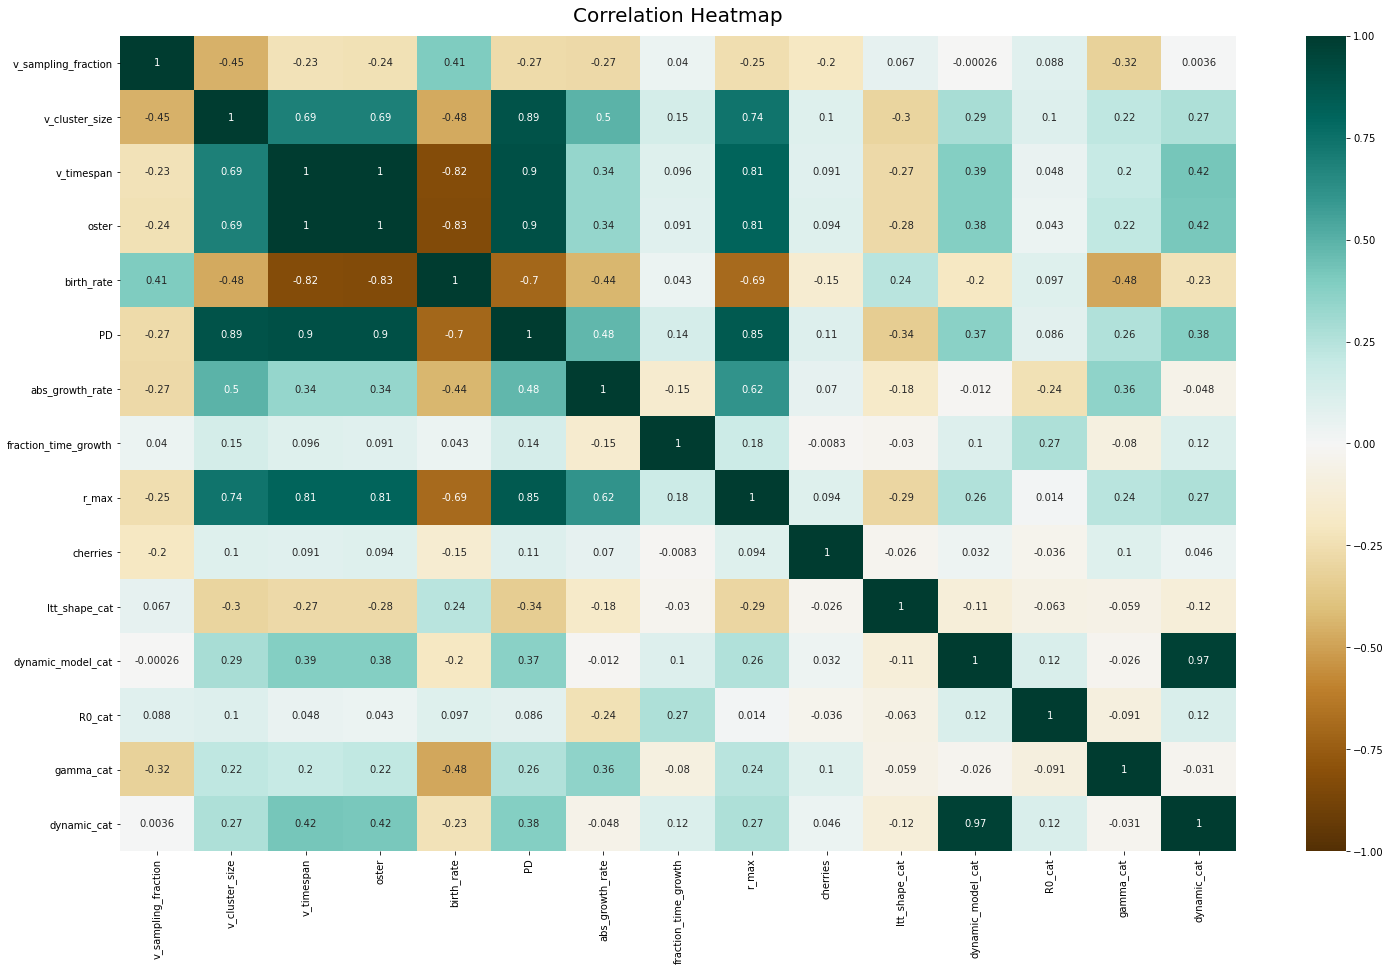

In [45]:
# Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(25, 15))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr('spearman'), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=14);

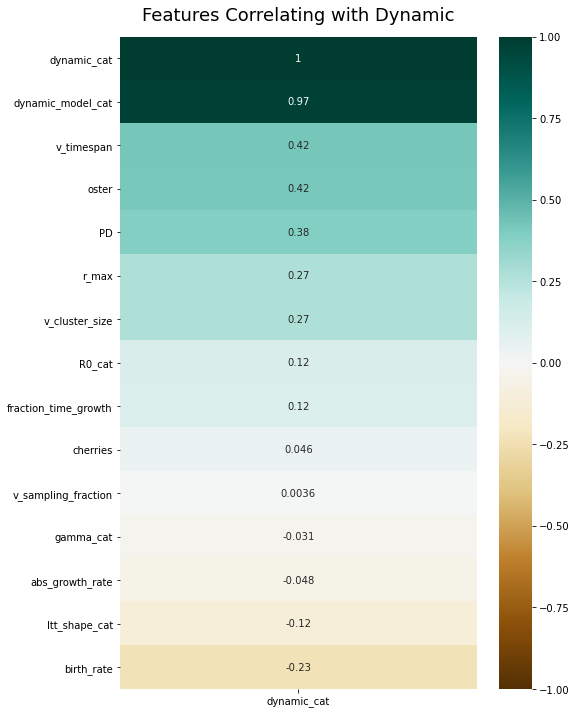

In [46]:
#check the features that are highly correlated to the output variable with Spearman
plt.figure(figsize=(8, 12))
heatmap_outputvar = sns.heatmap(aly_df.corr('spearman')[['dynamic_cat']].sort_values(by='dynamic_cat', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap_outputvar.set_title('Features Correlating with Dynamic', fontdict={'fontsize':18}, pad=16);

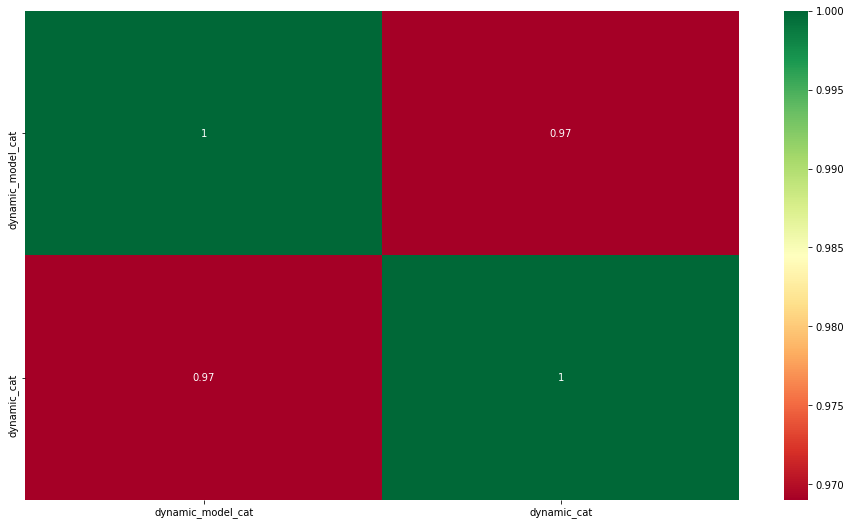

In [47]:
# most correlated features on spearman

corrmat = aly_df.corr('spearman')
top_corr_features = corrmat.index[abs(corrmat['dynamic_cat'])>0.5]
plt.figure(figsize=(16,9))
g = sns.heatmap(aly_df[top_corr_features].corr('spearman'),annot=True,cmap="RdYlGn")

#### From the above correlation plots it is evident that the features that really matter the most are:

* dynamic_model
* v_timespan
* oster
* PD
* r_max

#### oster and v_timespan have a perfect positive correlation (with correlation coefficient value = 1.0)?

#### Spearm Correlation between num_feat_cols and label

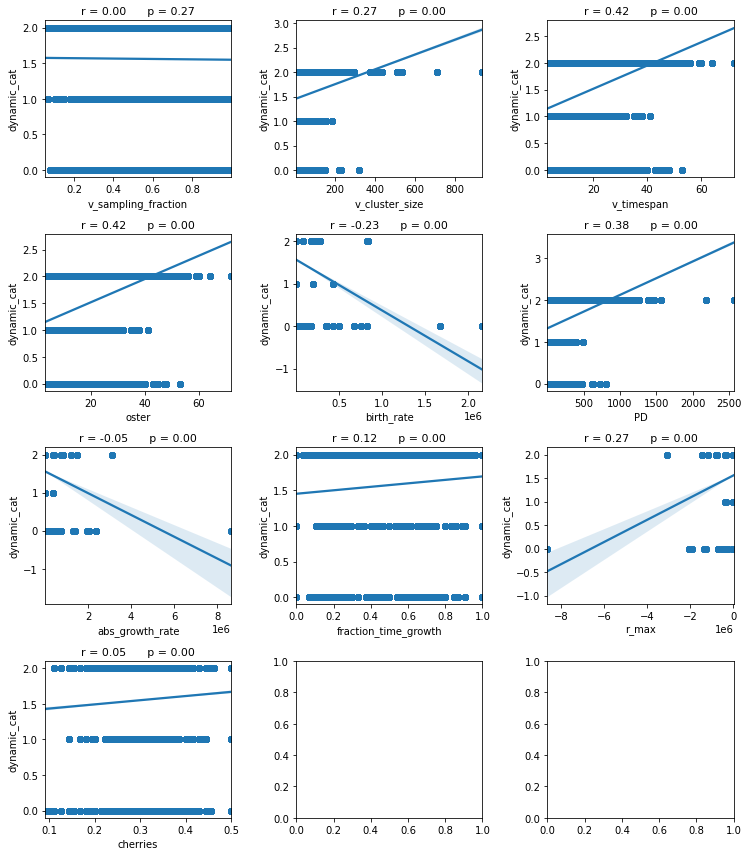

In [48]:
nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_plot_num_feats = [c for c in list(num_feat_cols) ]

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=aly_df[li_plot_num_feats[i]], y=aly_df['dynamic_cat'], ax = axs[r][c])
            # stp = stats.pearsonr(aly_df[num_feat_cols[i]], input_df['dynamic_cat'])
            stp = stats.spearmanr(aly_df[num_feat_cols[i]], aly_df['dynamic_cat'])
          
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

## Processing for Modeling

### Processing-1. One-hot encoding for the categorical feature
* ltt_shape_cat
* dynamic_model_cat
* R0_cat
* gamma_cat

In [49]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

cat_feat_cols = list(set(cat_feat_cols) - {'dynamic_model_cat'}) # ['ltt_shape_cat', 'R0_cat', 'gamma_cat']
print(cat_feat_cols)
cat_onehot_feat = []
org_idx = node_df.index

for cat_feat in cat_feat_cols:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    x = enc.fit_transform(node_df[cat_feat].values.reshape(-1, 1))
    n_dims = x.shape[-1]
    columns = [f'{cat_feat}_{i}' for i in range(n_dims)]
    cat_onehot_feat += columns
    cat_df = pd.DataFrame(x, index=org_idx, columns=columns)
    node_df = pd.concat([node_df, cat_df], axis=1)

['gamma_cat', 'ltt_shape_cat', 'R0_cat']


In [50]:
node_df

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,R0_cat_0,R0_cat_1,R0_cat_2
1149,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1150,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1151,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1152,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1153,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586160,c8,971,E,static,stable,0.983940,12.0,6.0,1.574702,6.057895,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
586161,c8,971,E,static,stable,0.983940,12.0,6.0,1.574702,6.057895,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
586162,c8,971,E,static,stable,0.983940,12.0,6.0,1.574702,6.057895,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
586163,c8,971,E,static,stable,0.983940,12.0,6.0,1.574702,6.057895,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Split the train/test sets (should put before imputing the missing values and calculating the correlation)

In [70]:
random_seed = 123
np.random.seed(random_seed)
os.makedirs(f'../data/split_rs{random_seed}', exist_ok=True)

from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 331, Test: 83
[ 309  863 3115 2155 3363 1091 2591 1596 1106 1113]


In [52]:
train_background_df = background_df[background_df['sim'].isin(train_ids)]
test_background_df = background_df[background_df['sim'].isin(test_ids)]
train_node_df = node_df[node_df['sim'].isin(train_ids)]
test_node_df = node_df[node_df['sim'].isin(test_ids)]

print(f'Train: {train_background_df.shape[0] + train_node_df.shape[0]}')
print(f'Test: {test_background_df.shape[0] + test_node_df.shape[0]}')
train_node_df.head()

Train: 467997
Test: 118168


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,R0_cat_0,R0_cat_1,R0_cat_2
1149,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1150,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1151,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1152,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1153,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Processing-2. Normalize the input features:
* Use Standardization
* Use MinMax normalization to normalize data to [0, 1]

array([[<AxesSubplot:title={'center':'v_sampling_fraction'}>,
        <AxesSubplot:title={'center':'v_cluster_size'}>,
        <AxesSubplot:title={'center':'v_timespan'}>],
       [<AxesSubplot:title={'center':'oster'}>,
        <AxesSubplot:title={'center':'birth_rate'}>,
        <AxesSubplot:title={'center':'PD'}>],
       [<AxesSubplot:title={'center':'abs_growth_rate'}>,
        <AxesSubplot:title={'center':'fraction_time_growth'}>,
        <AxesSubplot:title={'center':'r_max'}>],
       [<AxesSubplot:title={'center':'cherries'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

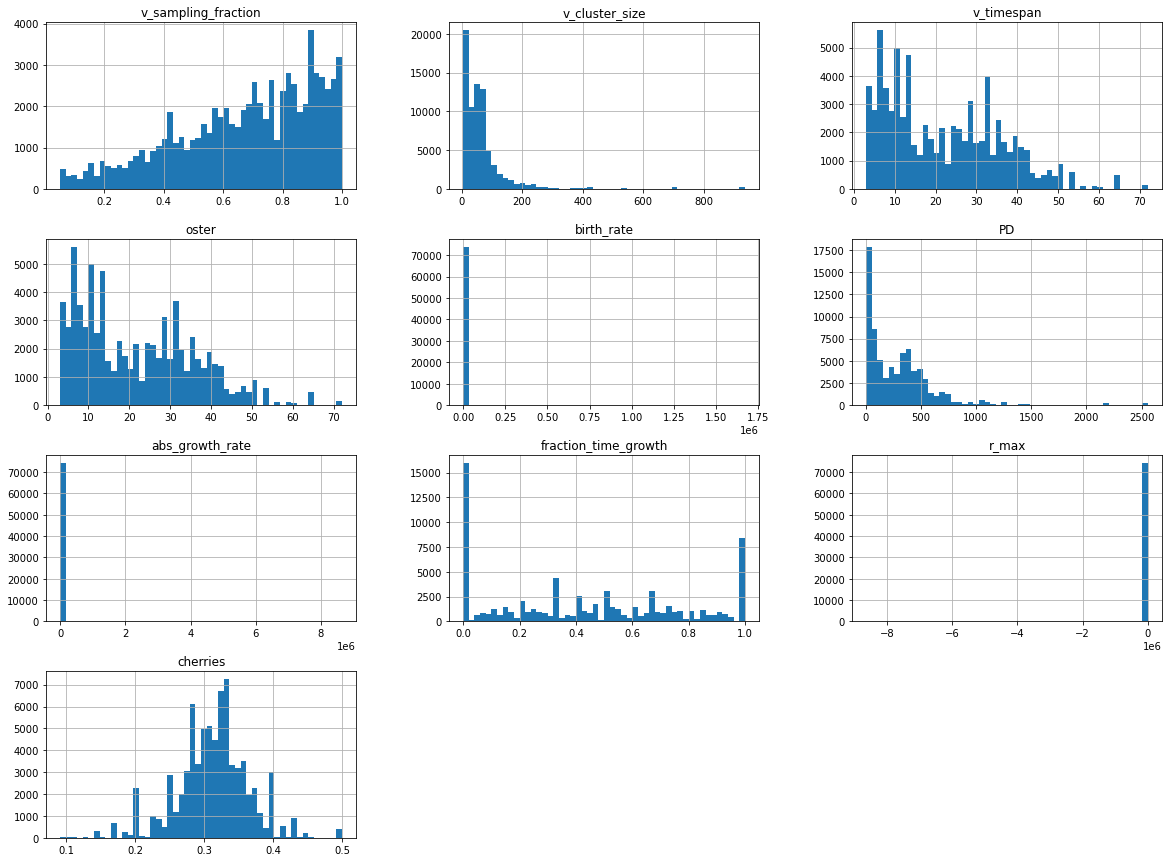

In [53]:
train_node_df[num_feat_cols].hist(bins=50,figsize=(20,15))

In [54]:
# Standardization non-category features
std_scaler = preprocessing.StandardScaler().fit(train_node_df[num_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in num_feat_cols]
norm_train_vals = std_scaler.transform(train_node_df[num_feat_cols])
norm_train_node_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_node_df.index)
train_node_df = pd.concat([train_node_df, norm_train_node_df], axis=1)

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'birth_rate-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>],
       [<AxesSubplot:title={'center':'abs_growth_rate-norm'}>,
        <AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>],
       [<AxesSubplot:title={'center':'cherries-norm'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

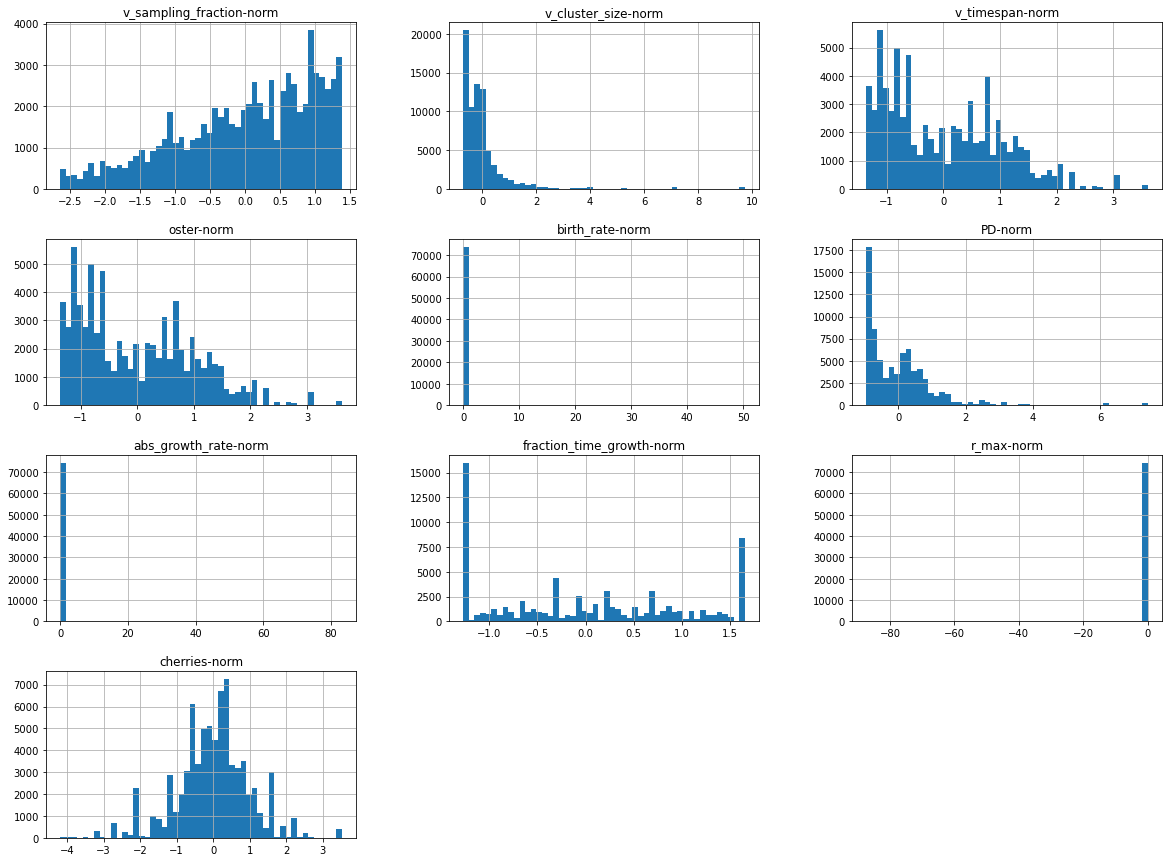

In [55]:
train_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [56]:
print(std_scaler.mean_, std_scaler.scale_)

[ 6.73784327e-01  6.84014598e+01  2.18946986e+01  2.19235204e+01
  1.81898594e+03  2.96569103e+02  2.97592630e+03  4.34250304e-01
 -2.43127211e+03  3.13048144e-01] [2.35483969e-01 8.91066873e+01 1.38756126e+01 1.38558357e+01
 3.31749395e+04 3.04763241e+02 1.03730412e+05 3.41886715e-01
 9.88835947e+04 5.30460933e-02]


In [57]:
norm_test_vals = std_scaler.transform(test_node_df[num_feat_cols])
norm_test_node_df = pd.DataFrame(norm_test_vals, columns=norm_num_feat_cols, index=test_node_df.index)
test_node_df = pd.concat([test_node_df, norm_test_node_df], axis=1)

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'birth_rate-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>],
       [<AxesSubplot:title={'center':'abs_growth_rate-norm'}>,
        <AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>],
       [<AxesSubplot:title={'center':'cherries-norm'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

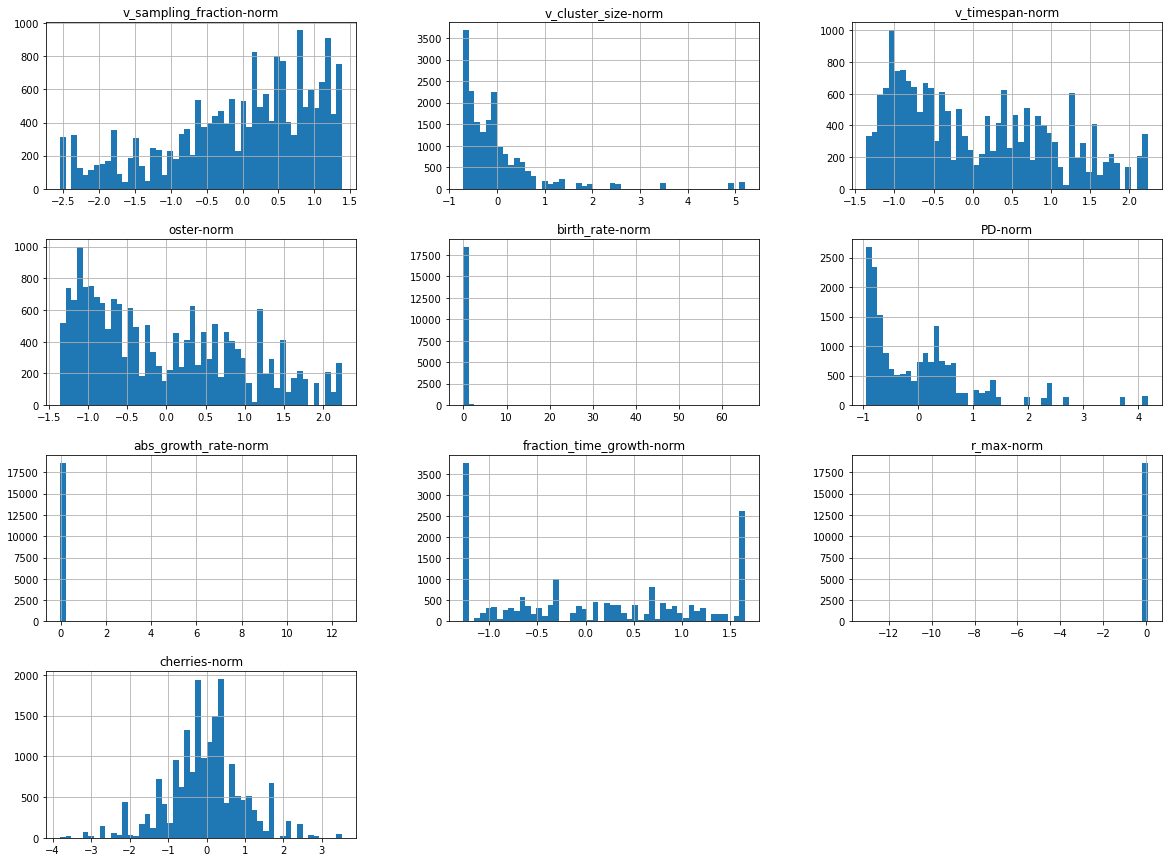

In [58]:
test_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [59]:
# Obtain the onehot features
import re
all_cols = node_df.columns.values

onehot_cols = []
for feat_name, pattern in zip(['ltt_shape_onehot', 'R0_onehot', 'gamma_onehot'], 
                              ['ltt_shape_cat_\d*', 'R0_cat_\d*', 'gamma_cat_\d']):
    for feat_col in all_cols:
        m = re.match(pattern, feat_col)
        if m:
            feat_dict.setdefault(feat_name, []).append(m.group(0))
            
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'dynamic_model': {0: 'exp', 1: 'lin', 2: 'stable'}, 'r0': {0: "(-inf, 0.0, 'right')", 1: "(0.0, 1.0, 'right')", 2: "(1.0, inf, 'right')"}, 'gamma': {0: "(0.432, inf, 'right')", 1: "(-0.472, 0.432, 'right')", 2: "(-86.171, -1.476, 'right')", 3: "(-1.476, -0.472, 'right')"}, 'dynamic': {0: 'decay', 1: 'growth', 2: 'static'}, 'ltt_shape_onehot': ['ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3'], 'R0_onehot': ['R0_cat_0', 'R0_cat_1', 'R0_cat_2'], 'gamma_onehot': ['gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']}


In [60]:
print(train_node_df.shape)
print(train_background_df.shape)

(74396, 47)
(393601, 19)


In [61]:
train_background_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,node
0,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,376
2,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440
3,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924
4,Background,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160


In [62]:
train_node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm
1149,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888
1150,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888
1151,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888
1152,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888
1153,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888


### Merge the background and non-background nodes

In [63]:
# train_full_df = train_node_df.merge(train_background_df, how='inner', left_on=list(train_background_df.columns), right_on=list(train_background_df.columns), left_index=True, right_index=True)
train_full_df = pd.concat([train_node_df, train_background_df])
print(f'Train: {train_full_df.shape}')

test_full_df = pd.concat([test_node_df, test_background_df])
print(f'Test: {test_full_df.shape}')

Train: (467997, 47)
Test: (118168, 47)


In [64]:
# Save the train/test to the disk
train_full_df.to_csv(f'{ds_folder}/train.csv', index=False)
test_full_df.to_csv(f'{ds_folder}/test.csv', index=False)

In [65]:
train_full_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm
1149,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888
1150,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888
1151,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888
1152,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888
1153,c1,1001,A,static,stable,0.537301,112.0,30.0,245.202603,30.011778,...,-0.579585,0.489285,0.58414,0.583744,-0.054828,1.064534,-0.028634,0.610164,0.025275,-0.304888


### Finalize the feature information and save to the file

In [67]:
all_cols = test_full_df.columns
print(all_cols)

Index(['cluster_id', 'sim', 'state', 'dynamic', 'dynamic_model',
       'v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'gamma', 'oster',
       'birth_rate', 'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth',
       'r_max', 'ltt_shape', 'cherries', 'node', 'R0_bin', 'R0_cat',
       'gamma_bin', 'gamma_cat', 'ltt_shape_cat', 'dynamic_model_cat',
       'dynamic_cat', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2',
       'gamma_cat_3', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2',
       'ltt_shape_cat_3', 'R0_cat_0', 'R0_cat_1', 'R0_cat_2',
       'v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm',
       'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm',
       'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm'],
      dtype='object')


In [68]:
onehot_cols = feat_dict['ltt_shape_onehot'] + feat_dict['R0_onehot'] + feat_dict['gamma_onehot']

raw_cols = num_feat_cols + cat_feat_cols
norm_onehot_cols = norm_num_feat_cols + onehot_cols
print(f'Raw cols: {raw_cols}', len(raw_cols))
print(f'Norm with onehot cols: {norm_onehot_cols}', len(norm_onehot_cols))

feat_dict['raw_feats'] = raw_cols
feat_dict['norm_onehot_feats'] = norm_onehot_cols

Raw cols: ['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'birth_rate', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'gamma_cat', 'ltt_shape_cat', 'R0_cat'] 13
Norm with onehot cols: ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'R0_cat_0', 'R0_cat_1', 'R0_cat_2', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3'] 21


In [69]:
import json 

with open('feat_dict.json', 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)